# Import Libraries

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['resized-2015-2019-blindness-detection-images', 'pretrained-pytorch-models', 'aptos-15-pretrained-resnet101', 'efficientnetomgpleasehalp', 'aptos2019-blindness-detection', 'efficientnet', 'fastai-pretrained-models', 'efficientnet-pytorch']


In [2]:
import fastai
from fastai.vision import *
fastai.__version__

'1.0.57'

In [3]:
from torch.nn import CrossEntropyLoss

# Copy Pretrained Weights to Where Pytorch Will Look

# Data Loading

## Read The CSVs

In [4]:
package_path = '/kaggle/input/efficientnet/efficientnet-pytorch/EfficientNet-PyTorch/'
sys.path.append(package_path)

In [5]:
train_label_15 = pd.read_csv('/kaggle/input/resized-2015-2019-blindness-detection-images/labels/trainLabels15.csv')

In [6]:
train_label_19 = pd.read_csv('/kaggle/input/resized-2015-2019-blindness-detection-images/labels/trainLabels19.csv')

In [7]:
test_label_15 = pd.read_csv('/kaggle/input/resized-2015-2019-blindness-detection-images/labels/testLabels15.csv')

In [8]:
train_label_15.level.value_counts()

0    25810
2     5292
1     2443
3      873
4      708
Name: level, dtype: int64

In [9]:
value_counts = np.array(train_label_15.level.value_counts(sort=False), dtype=np.float32)

In [10]:
value_counts

array([25810.,  2443.,  5292.,   873.,   708.], dtype=float32)

In [11]:
train_label_15.columns

Index(['image', 'level'], dtype='object')

In [12]:
train_label_19.diagnosis.value_counts()

0    1805
2     999
1     370
4     295
3     193
Name: diagnosis, dtype: int64

In [13]:
train_label_19.columns

Index(['id_code', 'diagnosis'], dtype='object')

In [14]:
test_label_15.level.value_counts()

0    39533
2     7861
1     3762
3     1214
4     1206
Name: level, dtype: int64

In [15]:
test_label_15.columns

Index(['image', 'level', 'Usage'], dtype='object')

## Load Data

In [16]:
aptos19_stats = ([0.42, 0.22, 0.075], [0.27, 0.15, 0.081])

In [17]:
import glob
import cv2
import numpy as np

def crop_image_from_gray(img,tol=7):
    """
    Crop out black borders
    https://www.kaggle.com/ratthachat/aptos-updated-preprocessing-ben-s-cropping
    """  
    
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        mask = gray_img>tol        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0):
            return img
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
        return img


def circle_crop(img):   
    """
    Create circular crop around image centre    
    """    
    
    img = cv2.imread(img)
    img = crop_image_from_gray(img)    
    
    height, width, depth = img.shape    
    
    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))
    
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    return img 

class APTOSImageList(ImageList):
    def open(self, fn:PathOrStr) -> Image:
        img = circle_crop(str(fn))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img / 255.0
        return Image(px=pil2tensor(img, np.float32))

path = Path("/kaggle/input/resized-2015-2019-blindness-detection-images")
src = (
    APTOSImageList.from_folder(path, presort=True, recurse=True)
        .filter_by_func(lambda item: item.parts[-2] != "resized test 19")
        .filter_by_func(lambda item: item.parts[-2] != "resized test 15")
        .filter_by_func(lambda item: item.parts[-2] != "resized train 15")
)

In [18]:
src=src.split_by_rand_pct(0.2,42)
#src=src.split_by_valid_func(lambda item: item.parts[-2] == "resized train 19")

## Label the Data

In [19]:
train_label_15_dict = dict(zip(list(train_label_15.image), list(train_label_15.level)))

In [20]:
train_label_19_dict = dict(zip(list(train_label_19.id_code), list(train_label_19.diagnosis)))

In [21]:
test_label_15_dict = dict(zip(list(test_label_15.image), list(test_label_15.level)))

In [22]:
def label_func(item):
    if item.parts[-2] == "resized train 15":
        return train_label_15_dict[item.stem]
    elif item.parts[-2] == "resized test 15":
        return test_label_15_dict[item.stem]
    elif item.parts[-2] == "resized train 19":
        return train_label_19_dict[item.stem]
    else:
        assert(False)

In [23]:
src = src.label_from_func(label_func)

## Transformations

In [24]:
tfms = ([dihedral(), 
         contrast(scale=(1.5, 3.0)), 
         brightness(change=(0.5, 0.60)), 
         rotate(degrees=(-180, 180))], 
        [contrast(scale=(1.5, 3.0)), 
         brightness(change=(0.5, 0.60)),])

## Create Databunch

In [25]:
data = (
    src.transform(tfms,size=256, resize_method=ResizeMethod.PAD, padding_mode='zeros')
    .databunch(bs=4)
    .normalize(aptos19_stats)
)

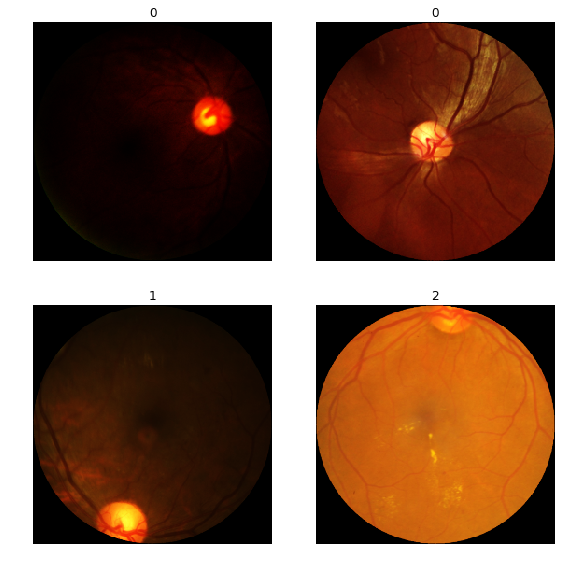

In [26]:
data.show_batch()

In [27]:
model_path='/kaggle/input/efficientnet-pytorch/efficientnet-b5-586e6cc6.pth'

In [28]:
def EfficientNetB5(pretrained=True):
    """Constructs a EfficientNet model for FastAI.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = EfficientNet.from_name('efficientnet-b5', override_params={'num_classes':5})

    if pretrained:
        model_state = torch.load(model_path)
        # load original weights apart from its head
        if '_fc.weight' in model_state.keys():
            model_state.pop('_fc.weight')
            model_state.pop('_fc.bias')
            res = model.load_state_dict(model_state, strict=False)
            assert str(res.missing_keys) == str(['_fc.weight', '_fc.bias']), 'issue loading pretrained weights'
        else:
            # A basic remapping is required
            from collections import OrderedDict
            mapping = { i:o for i,o in zip(model_state.keys(), model.state_dict().keys()) }
            mapped_model_state = OrderedDict([
                (mapping[k], v) for k,v in model_state.items() if not mapping[k].startswith('_fc')
            ])
            res = model.load_state_dict(mapped_model_state, strict=False)
            print(res)
    return model

In [29]:
from efficientnet_pytorch import EfficientNet

In [30]:
model = EfficientNetB5(pretrained=True)

In [31]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=3., reduction='mean'):
        super().__init__()
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        CE_loss = LabelSmoothingCrossEntropy(reduction='none')(inputs, targets)
        pt = torch.exp(-CE_loss)
        F_loss = ((1 - pt)**self.gamma) * CE_loss
        if self.reduction == 'sum':
            return F_loss.sum()
        elif self.reduction == 'mean':
            return F_loss.mean()

In [32]:
kappa = KappaScore()
kappa.weights = "quadratic"
precision = Precision(average="macro")
recall = Recall(average="macro")
loss_func = FocalLoss()

In [33]:
learn = Learner(data, model,
                    loss_func=loss_func,metrics=[kappa,accuracy],
                    model_dir='/kaggle/working')

In [34]:
learn.load('/kaggle/input/efficientnetomgpleasehalp/pretrained_focal_smooth_gen1_effi5')

Learner(data=ImageDataBunch;

Train: LabelList (2930 items)
x: APTOSImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
4,1,0,0,4
Path: /kaggle/input/resized-2015-2019-blindness-detection-images;

Valid: LabelList (732 items)
x: APTOSImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
0,1,3,4,0
Path: /kaggle/input/resized-2015-2019-blindness-detection-images;

Test: None, model=EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
        (stat

In [35]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 6.31E-07
Min loss divided by 10: 9.12E-08


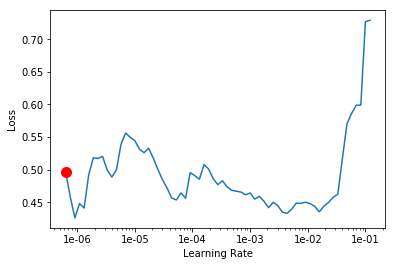

In [36]:
# Find a good learning rate
learn.recorder.plot(suggestion=True)

In [37]:
lr = 2e-3
learn.fit_one_cycle(6, slice(lr))

epoch,train_loss,valid_loss,kappa_score,accuracy,time
0,0.273547,0.462967,0.785096,0.684426,05:40
1,0.292067,0.283038,0.820020,0.760929,05:19
2,0.359486,0.392150,0.597391,0.714481,05:09
3,0.271940,0.277188,0.811292,0.733607,05:12


In [38]:
learn.unfreeze()

In [39]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


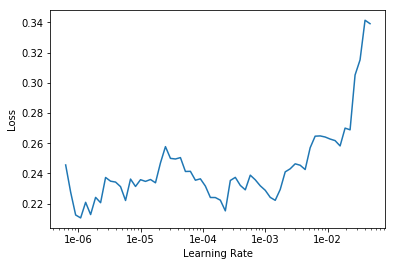

In [40]:
learn.recorder.plot()

In [41]:
learn.fit_one_cycle(4,slice(1e-6))

epoch,train_loss,valid_loss,kappa_score,accuracy,time
0,0.222405,0.236969,0.867255,0.807377,05:15
1,0.203755,0.233816,0.874231,0.812842,05:17
2,0.239190,0.235789,0.871915,0.814208,05:05
3,0.215599,0.232356,0.873136,0.816940,04:56


In [42]:
learn.validate()

[0.2346891, tensor(0.8732), tensor(0.8142)]

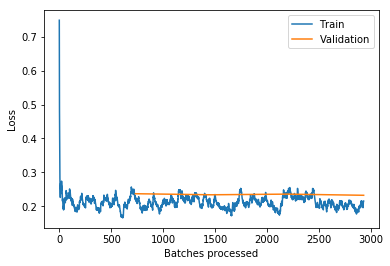

In [43]:
learn.recorder.plot_losses()

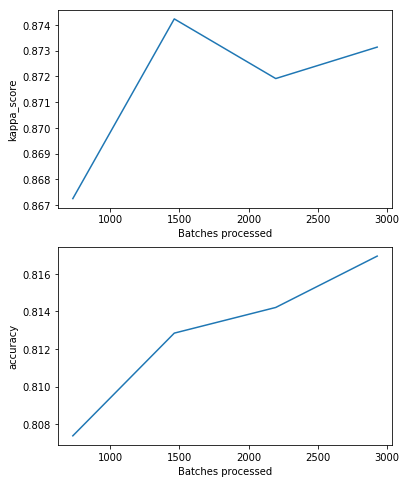

In [44]:
learn.recorder.plot_metrics()

In [45]:
learn.save('/kaggle/working/pretrained_focal_smooth_gen1_effi5')

In [46]:
PATH = Path('/kaggle/input/aptos2019-blindness-detection')
sample_df = pd.read_csv(PATH/'sample_submission.csv')
sample_df.head()

,id_code,diagnosis
0,0005cfc8afb6,0
1,003f0afdcd15,0
2,006efc72b638,0
3,00836aaacf06,0
4,009245722fa4,0


In [47]:
learn.data.add_test(ImageList.from_df(sample_df,PATH,folder='test_images',suffix='.png'))
preds,y = learn.get_preds(DatasetType.Test)

In [48]:
sample_df.diagnosis = preds.argmax(1)

In [49]:
sample_df.to_csv('/kaggle/working/submission.csv',index=False)

/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 